In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report,accuracy_score, precision_score, make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor

from catboost import CatBoostClassifier
import lightgbm as lgb

In [255]:
raw_df = pd.read_csv('Train_clean.csv')
raw_df.set_index('ID',inplace=True)
raw_df.reset_index(drop=True,inplace=True)
raw_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster,Target,region_encoded
0,24,599.998474,44.664513,136932.718750,57697.367188,47.254963,293.933075,1.555526,2.071044,1.079161,3,0.984065,0.020825,0.945181,2897.742592,Astral,E,0,14
1,24,4764.960000,41.000000,4756.840000,1585.470000,41.000000,2.000000,626.000000,24.000000,6.433506,62,31.000000,0.756098,1.000000,116.020488,Nebula,D,0,8
2,24,5769.230000,22.000000,5769.230000,1923.080000,22.000000,28121.000000,0.000000,9.944307,1.000000,61,5.318420,0.241746,1.000000,262.237727,Celestial,C,0,1
3,24,176.783722,39.507954,136199.484375,55805.335938,41.238922,221.357040,1.530284,7.256878,2.985912,6,1.143136,0.027720,0.958026,3302.692635,Astral,B,0,14
4,24,5341.880000,58.000000,5636.750000,1879.060000,60.000000,1131.000000,546.000000,376.000000,0.000000,62,31.000000,0.516667,0.966667,93.945833,Eclipsara,D,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507829,24,7179.490000,17.000000,6972.220000,2323.930000,18.000000,4269.000000,7.000000,73.967003,11.000000,41,4.000000,0.222222,0.944444,387.345556,Mandalore,C,0,14
1507830,24,854.700000,2.000000,854.700000,285.040000,2.000000,2276.000000,0.000000,2.039146,1.507859,36,2.000000,1.000000,1.000000,427.350000,Celestial,A,0,1
1507831,24,1923.080000,9.000000,2136.750000,712.390000,10.000000,2.112210,34.000000,74.000000,48.000000,40,10.000000,1.000000,0.900000,213.675000,Luminous,A,0,6
1507832,24,624.666809,43.581985,130151.312500,50710.792969,68.589172,0.000000,5.300038,3.276555,0.449188,39,1.117620,0.016294,0.635406,1897.548957,Astral,A,0,0


In [256]:
raw_df.Target.value_counts()

0    1225319
1     282515
Name: Target, dtype: int64

In [257]:
test_df = pd.read_csv('Test_clean.csv')
test_df.set_index('ID',inplace=True)
test_df.drop(columns=['Target','region_encoded'],inplace=True)
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster
ID,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24,2008.550000,16.00000,2010.26000,670.090000,17.000000,10.000000,247.000000,17.000000,70.000000,59,11.000000,0.647059,0.941176,118.250588,Droidika,A
ID_04KNWHGV5783,24,2991.450000,14.00000,2991.45000,997.010000,17.000000,10.555660,99.000000,100.000000,84.000000,49,12.000000,0.705882,0.823529,175.967647,Luminous,A
ID_CXS07G6VLB2U,24,1581.200000,8.00000,1578.21000,526.070000,8.000000,436.000000,47.000000,113.000000,5.000000,13,6.000000,0.750000,1.000000,197.276250,Astral,A
ID_N3NFJJVHS25K,24,2564.100000,12.00000,2777.78000,926.070000,13.000000,0.000000,135.000000,181.000000,3.568766,53,13.000000,1.000000,0.923077,213.675385,Eclipsara,A
ID_R36J4ROT93E9,24,574.959717,42.13829,136932.71875,57717.339844,59.322701,291.771881,1.612311,2.899877,1.758302,1,0.988371,0.016661,0.710323,2308.268464,Astral,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24,4273.500000,19.00000,4487.18000,1495.730000,20.000000,1.489634,60.000000,208.000000,80.000000,54,20.000000,1.000000,0.950000,224.359000,Stellaris,C
ID_XGDT520DFBLP,24,6901.710000,41.00000,7115.38000,2371.790000,41.000000,7019.000000,105.000000,257.000000,5.000000,59,33.000000,0.804878,1.000000,173.545854,Mandalore,D
ID_9RDB792PB5Q4,24,1702.038574,1.43294,42.31000,14.100000,1.000000,0.000000,1.000000,1.000000,0.888619,43,1.028045,1.028045,1.432940,42.310000,Mandalore,A


Log Transform & Scaling

In [258]:
raw_data = pd.read_csv('train_clean_filled.csv')
raw_df['Null_count'] = raw_data['Null_Count']
raw_df.drop(columns='region_encoded',inplace=True)
raw_data['cluster'] = raw_df['cluster']
raw_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster,Target,Null_count
0,24,599.998474,44.664513,136932.718750,57697.367188,47.254963,293.933075,1.555526,2.071044,1.079161,3,0.984065,0.020825,0.945181,2897.742592,Astral,E,0,14
1,24,4764.960000,41.000000,4756.840000,1585.470000,41.000000,2.000000,626.000000,24.000000,6.433506,62,31.000000,0.756098,1.000000,116.020488,Nebula,D,0,3
2,24,5769.230000,22.000000,5769.230000,1923.080000,22.000000,28121.000000,0.000000,9.944307,1.000000,61,5.318420,0.241746,1.000000,262.237727,Celestial,C,0,5
3,24,176.783722,39.507954,136199.484375,55805.335938,41.238922,221.357040,1.530284,7.256878,2.985912,6,1.143136,0.027720,0.958026,3302.692635,Astral,B,0,14
4,24,5341.880000,58.000000,5636.750000,1879.060000,60.000000,1131.000000,546.000000,376.000000,0.000000,62,31.000000,0.516667,0.966667,93.945833,Eclipsara,D,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507829,24,7179.490000,17.000000,6972.220000,2323.930000,18.000000,4269.000000,7.000000,73.967003,11.000000,41,4.000000,0.222222,0.944444,387.345556,Mandalore,C,0,2
1507830,24,854.700000,2.000000,854.700000,285.040000,2.000000,2276.000000,0.000000,2.039146,1.507859,36,2.000000,1.000000,1.000000,427.350000,Celestial,A,0,4
1507831,24,1923.080000,9.000000,2136.750000,712.390000,10.000000,2.112210,34.000000,74.000000,48.000000,40,10.000000,1.000000,0.900000,213.675000,Luminous,A,0,3
1507832,24,624.666809,43.581985,130151.312500,50710.792969,68.589172,0.000000,5.300038,3.276555,0.449188,39,1.117620,0.016294,0.635406,1897.548957,Astral,A,0,12


In [259]:
raw_df.columns

Index(['tenure', 'Amount', 'refill_frequency', 'revenue', 'arpu_segment',
       'frequency', 'data_volume', 'on_net', 'Procuct_1', 'Procuct_2',
       'regularity', 'freq_top_pack', 'pct_top_refill', 'pct_of_refill',
       'pct_revenue', 'region', 'cluster', 'Target', 'Null_count'],
      dtype='object')

In [260]:
test_df.columns

Index(['tenure', 'Amount', 'refill_frequency', 'revenue', 'arpu_segment',
       'frequency', 'data_volume', 'on_net', 'Procuct_1', 'Procuct_2',
       'regularity', 'freq_top_pack', 'pct_top_refill', 'pct_of_refill',
       'pct_revenue', 'region', 'cluster'],
      dtype='object')

In [261]:
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster
ID,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24,2008.550000,16.00000,2010.26000,670.090000,17.000000,10.000000,247.000000,17.000000,70.000000,59,11.000000,0.647059,0.941176,118.250588,Droidika,A
ID_04KNWHGV5783,24,2991.450000,14.00000,2991.45000,997.010000,17.000000,10.555660,99.000000,100.000000,84.000000,49,12.000000,0.705882,0.823529,175.967647,Luminous,A
ID_CXS07G6VLB2U,24,1581.200000,8.00000,1578.21000,526.070000,8.000000,436.000000,47.000000,113.000000,5.000000,13,6.000000,0.750000,1.000000,197.276250,Astral,A
ID_N3NFJJVHS25K,24,2564.100000,12.00000,2777.78000,926.070000,13.000000,0.000000,135.000000,181.000000,3.568766,53,13.000000,1.000000,0.923077,213.675385,Eclipsara,A
ID_R36J4ROT93E9,24,574.959717,42.13829,136932.71875,57717.339844,59.322701,291.771881,1.612311,2.899877,1.758302,1,0.988371,0.016661,0.710323,2308.268464,Astral,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24,4273.500000,19.00000,4487.18000,1495.730000,20.000000,1.489634,60.000000,208.000000,80.000000,54,20.000000,1.000000,0.950000,224.359000,Stellaris,C
ID_XGDT520DFBLP,24,6901.710000,41.00000,7115.38000,2371.790000,41.000000,7019.000000,105.000000,257.000000,5.000000,59,33.000000,0.804878,1.000000,173.545854,Mandalore,D
ID_9RDB792PB5Q4,24,1702.038574,1.43294,42.31000,14.100000,1.000000,0.000000,1.000000,1.000000,0.888619,43,1.028045,1.028045,1.432940,42.310000,Mandalore,A


In [262]:
raw_test = pd.read_csv('test_clean_filled.csv')
raw_test.set_index('ID',inplace=True)
raw_test['cluster'] = test_df['cluster']
raw_test

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Null_Count,cluster
ID,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,Droidika,24.0,2008.550,16.0,2010.26,670.09,17.0,10.0,247.0,17.0,70.0,1.0,1.0,59,11.0,2,A
ID_04KNWHGV5783,Luminous,24.0,2991.450,14.0,2991.45,997.01,17.0,807.5,99.0,100.0,84.0,1.0,1.0,49,12.0,3,A
ID_CXS07G6VLB2U,Astral,24.0,1581.200,8.0,1578.21,526.07,8.0,436.0,47.0,113.0,5.0,1.0,1.0,13,6.0,2,A
ID_N3NFJJVHS25K,Eclipsara,24.0,2564.100,12.0,2777.78,926.07,13.0,0.0,135.0,181.0,4.0,1.0,1.0,53,13.0,3,A
ID_R36J4ROT93E9,Mandalore,24.0,1391.025,7.0,1343.16,447.86,9.0,309.0,26.0,31.0,7.0,1.0,1.0,1,5.0,14,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,Stellaris,24.0,4273.500,19.0,4487.18,1495.73,20.0,60.0,60.0,208.0,80.0,1.0,1.0,54,20.0,3,C
ID_XGDT520DFBLP,Mandalore,24.0,6901.710,41.0,7115.38,2371.79,41.0,7019.0,105.0,257.0,5.0,1.0,1.0,59,33.0,3,D
ID_9RDB792PB5Q4,Mandalore,24.0,2008.550,9.0,42.31,14.10,1.0,0.0,1.0,1.0,7.0,1.0,2.0,43,6.0,7,A


In [263]:
test_df['Null_count'] = raw_test['Null_Count']
test_df

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster,Null_count
ID,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24,2008.550000,16.00000,2010.26000,670.090000,17.000000,10.000000,247.000000,17.000000,70.000000,59,11.000000,0.647059,0.941176,118.250588,Droidika,A,2
ID_04KNWHGV5783,24,2991.450000,14.00000,2991.45000,997.010000,17.000000,10.555660,99.000000,100.000000,84.000000,49,12.000000,0.705882,0.823529,175.967647,Luminous,A,3
ID_CXS07G6VLB2U,24,1581.200000,8.00000,1578.21000,526.070000,8.000000,436.000000,47.000000,113.000000,5.000000,13,6.000000,0.750000,1.000000,197.276250,Astral,A,2
ID_N3NFJJVHS25K,24,2564.100000,12.00000,2777.78000,926.070000,13.000000,0.000000,135.000000,181.000000,3.568766,53,13.000000,1.000000,0.923077,213.675385,Eclipsara,A,3
ID_R36J4ROT93E9,24,574.959717,42.13829,136932.71875,57717.339844,59.322701,291.771881,1.612311,2.899877,1.758302,1,0.988371,0.016661,0.710323,2308.268464,Astral,E,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24,4273.500000,19.00000,4487.18000,1495.730000,20.000000,1.489634,60.000000,208.000000,80.000000,54,20.000000,1.000000,0.950000,224.359000,Stellaris,C,3
ID_XGDT520DFBLP,24,6901.710000,41.00000,7115.38000,2371.790000,41.000000,7019.000000,105.000000,257.000000,5.000000,59,33.000000,0.804878,1.000000,173.545854,Mandalore,D,3
ID_9RDB792PB5Q4,24,1702.038574,1.43294,42.31000,14.100000,1.000000,0.000000,1.000000,1.000000,0.888619,43,1.028045,1.028045,1.432940,42.310000,Mandalore,A,7


In [264]:
scaler = RobustScaler()

In [265]:
#df = raw_df.copy().drop(columns=['Amount','refill_frequency','revenue'])
df = raw_df.copy()
df_log = np.log(df.iloc[:,0:15]+1)
df_log


,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue
0,3.218876,6.398592,3.821321,11.827252,10.962984,3.876499,5.686748,0.938258,1.122018,0.731964,1.386294,0.685148,0.020611,0.665355,7.972032
1,3.218876,8.469254,3.737670,8.467549,7.369267,3.737670,1.098612,6.440947,3.218876,2.005998,4.143135,3.465736,0.563094,0.693147,4.762349
2,3.218876,8.660467,3.135494,8.660467,7.562203,3.135494,10.244307,0.000000,2.392819,0.693147,4.127134,1.843469,0.216519,0.693147,5.573058
3,3.218876,5.180568,3.701498,11.821883,10.929643,3.743342,5.404284,0.928332,2.111047,1.382766,1.945910,0.762270,0.027343,0.671937,8.102796
4,3.218876,8.583520,4.077537,8.637240,7.539059,4.110874,7.031741,6.304449,5.932245,0.000000,4.143135,3.465736,0.416515,0.676340,4.553307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507829,3.218876,8.879123,2.890372,8.849832,7.751445,2.944439,8.359369,2.079442,4.317048,2.484907,3.737670,1.609438,0.200671,0.664976,5.961896
1507830,3.218876,6.751920,1.098612,6.751920,5.656132,1.098612,7.730614,0.000000,1.111576,0.919430,3.610918,1.098612,0.693147,0.693147,6.059941
1507831,3.218876,7.562203,2.302585,7.667509,6.570028,2.397895,1.135333,3.555348,4.317488,3.891820,3.713572,2.397895,0.693147,0.641854,5.369125
1507832,3.218876,6.438818,3.797330,11.776461,10.833914,4.242609,0.000000,1.840556,1.453148,0.371004,3.688879,0.750293,0.016163,0.491891,7.548845


In [266]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_log),columns=df_log.columns)
#df_scaled = df_log
features = pd.concat([df_scaled,df.iloc[:,15:]],axis=1)
#features = pd.concat([df_scaled,df.cluster],axis=1)
features

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster,Target,Null_count
0,0.0,-0.034869,0.500716,0.733144,0.748858,0.422483,0.066469,-0.368099,-0.416131,-0.486614,-0.913854,-0.298252,-0.601821,0.326625,0.885344,Astral,E,0,14
1,0.0,1.058399,0.460777,0.077104,0.074063,0.355890,-0.895591,1.406843,0.466116,0.896981,0.460900,1.707519,0.394462,0.479911,-0.206389,Nebula,D,0,3
2,0.0,1.159355,0.173269,0.114774,0.110291,0.067040,1.022118,-0.670743,0.118555,-0.528769,0.452921,0.537301,-0.242032,0.479911,0.069363,Celestial,C,0,5
3,0.0,-0.677962,0.443507,0.732095,0.742597,0.358611,0.007241,-0.371301,0.000000,0.220154,-0.634790,-0.242619,-0.589458,0.362925,0.929821,Astral,B,0,14
4,0.0,1.118729,0.623047,0.110239,0.105945,0.534907,0.348493,1.362814,1.607758,-1.281524,0.460900,1.707519,0.125266,0.387212,-0.277492,Eclipsara,D,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507829,0.0,1.274801,0.056235,0.151751,0.145825,-0.024604,0.626876,0.000000,0.928169,1.417074,0.258707,0.368483,-0.271137,0.324535,0.201622,Mandalore,C,0,2
1507830,0.0,0.151681,-0.799238,-0.257902,-0.247614,-0.910004,0.495036,-0.670743,-0.420524,-0.283027,0.195500,0.000000,0.633308,0.479911,0.234970,Celestial,A,0,4
1507831,0.0,0.579494,-0.224403,-0.079118,-0.076011,-0.286768,-0.887891,0.476067,0.928354,2.944976,0.246690,0.937235,0.633308,0.197003,-0.000002,Luminous,A,0,3
1507832,0.0,-0.013631,0.489262,0.723226,0.724622,0.598097,-1.125953,-0.077055,-0.276809,-0.878615,0.234377,-0.251259,-0.609989,-0.630116,0.741402,Astral,A,0,12


In [267]:
df_test

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,regularity,freq_top_pack,pct_top_refill,pct_of_refill,pct_revenue,region,cluster,Null_count
ID,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,24,2008.550000,16.00000,2010.26000,670.090000,17.000000,10.000000,247.000000,17.000000,70.000000,59,11.000000,0.647059,0.941176,118.250588,Droidika,A,2
ID_04KNWHGV5783,24,2991.450000,14.00000,2991.45000,997.010000,17.000000,10.555660,99.000000,100.000000,84.000000,49,12.000000,0.705882,0.823529,175.967647,Luminous,A,3
ID_CXS07G6VLB2U,24,1581.200000,8.00000,1578.21000,526.070000,8.000000,436.000000,47.000000,113.000000,5.000000,13,6.000000,0.750000,1.000000,197.276250,Astral,A,2
ID_N3NFJJVHS25K,24,2564.100000,12.00000,2777.78000,926.070000,13.000000,0.000000,135.000000,181.000000,3.568766,53,13.000000,1.000000,0.923077,213.675385,Eclipsara,A,3
ID_R36J4ROT93E9,24,574.959717,42.13829,136932.71875,57717.339844,59.322701,291.771881,1.612311,2.899877,1.758302,1,0.988371,0.016661,0.710323,2308.268464,Astral,E,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,24,4273.500000,19.00000,4487.18000,1495.730000,20.000000,1.489634,60.000000,208.000000,80.000000,54,20.000000,1.000000,0.950000,224.359000,Stellaris,C,3
ID_XGDT520DFBLP,24,6901.710000,41.00000,7115.38000,2371.790000,41.000000,7019.000000,105.000000,257.000000,5.000000,59,33.000000,0.804878,1.000000,173.545854,Mandalore,D,3
ID_9RDB792PB5Q4,24,1702.038574,1.43294,42.31000,14.100000,1.000000,0.000000,1.000000,1.000000,0.888619,43,1.028045,1.028045,1.432940,42.310000,Mandalore,A,7


In [268]:
df_test = test_df.copy()
test_log = np.log(df_test.iloc[:,0:15]+1)
test_features = pd.concat([test_log,test_df.iloc[:,15:]],axis=1)
final_test = pd.get_dummies(test_features)
final_test

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,3.218876,7.605666,2.833213,7.606517,6.508903,2.890372,2.397895,5.513429,2.890372,4.262680,...,0,0,0,0,0,1,0,0,0,0
ID_04KNWHGV5783,3.218876,8.003848,2.708050,8.003848,6.905763,2.890372,2.447175,4.605170,4.615121,4.442651,...,0,0,0,0,0,1,0,0,0,0
ID_CXS07G6VLB2U,3.218876,7.366572,2.197225,7.364680,6.267333,2.197225,6.079933,3.871201,4.736198,1.791759,...,0,0,0,0,0,1,0,0,0,0
ID_N3NFJJVHS25K,3.218876,7.849753,2.564949,7.929767,6.832029,2.639057,0.000000,4.912655,5.204007,1.519243,...,0,0,0,0,0,1,0,0,0,0
ID_R36J4ROT93E9,3.218876,6.356038,3.764411,11.827252,10.963330,4.099708,5.679394,0.960235,1.360945,1.014615,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,3.218876,8.360422,2.995732,8.409203,7.311038,3.044522,0.912136,4.110874,5.342334,4.394449,...,0,0,0,1,0,0,0,1,0,0
ID_XGDT520DFBLP,3.218876,8.839669,3.737670,8.870154,7.771822,3.737670,8.856518,4.663439,5.552960,1.791759,...,0,0,0,0,0,0,0,0,1,0
ID_9RDB792PB5Q4,3.218876,7.440169,0.889101,3.768384,2.714695,0.693147,0.000000,0.693147,0.693147,0.635846,...,0,0,0,0,0,1,0,0,0,0


In [123]:
features = pd.get_dummies(features)
targets = raw_df['Target']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

0    282515
1    282515
Name: Target, dtype: int64


In [106]:
features = pd.get_dummies(features)
targets = raw_df['Target']
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.3, random_state=0)

0    1225319
1    1225319
Name: Target, dtype: int64


Best Model

In [269]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [271]:
scaled_features = np.log(raw_df.drop(columns=['region','Target','Null_count','cluster',])+1)
scaled_features = pd.concat([scaled_features, raw_df[['region', 'Null_count', 'cluster']]], axis=1)
scaled_features
features = pd.get_dummies(scaled_features)
targets = raw_df['Target']


In [ ]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled  = rus.fit_resample(features,targets)
print(y_resampled.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=0)

In [272]:
test_log = np.log(test_df.drop(columns=['region','Null_count','cluster',])+1)
test_features = pd.concat([test_log, test_df[['region', 'Null_count', 'cluster']]], axis=1)
final_test = pd.get_dummies(test_features)
final_test

,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,...,region_Nebulith,region_Quasar,region_Radiantara,region_Stellaris,region_Zodiacalia,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E
ID,,,,,,,,,,,,,,,,,,,,,
ID_LZ8K373W7EWV,3.218876,7.605666,2.833213,7.606517,6.508903,2.890372,2.397895,5.513429,2.890372,4.262680,...,0,0,0,0,0,1,0,0,0,0
ID_04KNWHGV5783,3.218876,8.003848,2.708050,8.003848,6.905763,2.890372,2.447175,4.605170,4.615121,4.442651,...,0,0,0,0,0,1,0,0,0,0
ID_CXS07G6VLB2U,3.218876,7.366572,2.197225,7.364680,6.267333,2.197225,6.079933,3.871201,4.736198,1.791759,...,0,0,0,0,0,1,0,0,0,0
ID_N3NFJJVHS25K,3.218876,7.849753,2.564949,7.929767,6.832029,2.639057,0.000000,4.912655,5.204007,1.519243,...,0,0,0,0,0,1,0,0,0,0
ID_R36J4ROT93E9,3.218876,6.356038,3.764411,11.827252,10.963330,4.099708,5.679394,0.960235,1.360945,1.014615,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MGZSA4ICBD9O,3.218876,8.360422,2.995732,8.409203,7.311038,3.044522,0.912136,4.110874,5.342334,4.394449,...,0,0,0,1,0,0,0,1,0,0
ID_XGDT520DFBLP,3.218876,8.839669,3.737670,8.870154,7.771822,3.737670,8.856518,4.663439,5.552960,1.791759,...,0,0,0,0,0,0,0,0,1,0
ID_9RDB792PB5Q4,3.218876,7.440169,0.889101,3.768384,2.714695,0.693147,0.000000,0.693147,0.693147,0.635846,...,0,0,0,0,0,1,0,0,0,0


In [300]:
print(final_test.columns)
print(X_train.columns)
print(features.columns)

Index(['tenure', 'Amount', 'refill_frequency', 'revenue', 'arpu_segment',
       'frequency', 'data_volume', 'on_net', 'Procuct_1', 'Procuct_2',
       'regularity', 'freq_top_pack', 'pct_top_refill', 'pct_of_refill',
       'pct_revenue', 'Null_count', 'region_Astral', 'region_Celestial',
       'region_Droidika', 'region_Eclipsara', 'region_Eternum',
       'region_Forcehaven', 'region_Luminous', 'region_Mandalore',
       'region_Nebula', 'region_Nebulith', 'region_Quasar',
       'region_Radiantara', 'region_Stellaris', 'region_Zodiacalia',
       'cluster_A', 'cluster_B', 'cluster_C', 'cluster_D', 'cluster_E'],
      dtype='object')
Index(['tenure', 'Amount', 'refill_frequency', 'revenue', 'arpu_segment',
       'frequency', 'data_volume', 'on_net', 'Procuct_1', 'Procuct_2',
       'regularity', 'freq_top_pack', 'pct_top_refill', 'pct_of_refill',
       'pct_revenue', 'Null_count', 'region_Astral', 'region_Celestial',
       'region_Droidika', 'region_Eclipsara', 'region_Eternum',

In [342]:
features.drop(columns='lgb_pred',inplace=True)

In [344]:
over_sampler = RandomOverSampler(sampling_strategy=0.6)  # You can adjust the sampling strategy
under_sampler = RandomUnderSampler(sampling_strategy=0.6)  # You can adjust the sampling strategy

pipeline = Pipeline([
    ('over', over_sampler),
    ('under', under_sampler)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)

# Apply the pipeline to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
X_train, y_train = X_resampled, y_resampled 
print(X_train, y_train)

           tenure    Amount  refill_frequency    revenue  arpu_segment  \
0        3.218876  8.455711          2.944439   8.468627      7.370344   
1        3.218876  7.189764          2.197225   7.189439      6.092327   
2        3.218876  5.293133          0.800219   0.357674      0.000000   
3        3.218876  6.589614          1.386294   7.424547      6.327133   
4        3.218876  8.642093          3.808690  12.093084     11.047219   
...           ...       ...               ...        ...           ...   
1372693  3.218876  4.676686          3.569112  11.793470     10.859699   
1372694  3.218876  6.356038          3.764411  11.827252     10.963330   
1372695  3.218876  5.180568          3.701498  11.821883     10.929643   
1372696  2.564949  6.159884          3.747347  11.826415     10.912989   
1372697  3.218876  6.155049          1.609438   7.492532      6.395028   

         frequency  data_volume    on_net  Procuct_1  Procuct_2  ...  \
0         3.218876     9.390326  2.9444

In [345]:
y_train.value_counts()

0    857936
1    514762
Name: Target, dtype: int64

In [276]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.15,
    max_dephth = 3,
    n_estimators = 35,
    objective='binary:logistic',  
    eval_metric='auc',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dephth=3, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=35,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy: 0.8451263930560088
Confusion Matrix:
[[257604  48562]
 [  9819  60974]]
___________________________
F1 Score: 0.676252848959402
Feature ranking:


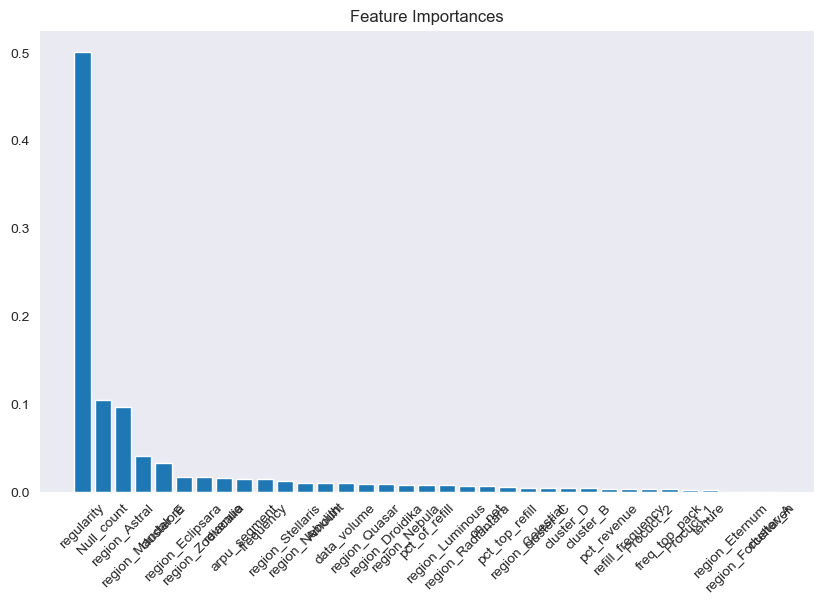

XGBoost Metrics:
Precision: 0.5567
Recall: 0.8613
F1 Score: 0.6763
AUC-ROC: 0.9220

________________________________________________________


In [277]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

Best Model predictions

In [278]:
y_pred = model_xgb.predict(features)
accuracy = accuracy_score(targets, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(targets, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(targets, y_pred)
print("F1 Score:", f1)
precision_xgb = precision_score(targets, y_pred)
recall_xgb = recall_score(targets, y_pred)
f1_xgb = f1_score(targets, y_pred)
auc_roc_xgb = roc_auc_score(targets, model_xgb.predict_proba(features)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

Accuracy: 0.8451527157498769
Confusion Matrix:
[[1031136  194183]
 [  39301  243214]]
___________________________
F1 Score: 0.6756770271922123
XGBoost Metrics:
Precision: 0.5560
Recall: 0.8609
F1 Score: 0.6757
AUC-ROC: 0.9222

________________________________________________________


In [251]:
final_pred = model_xgb.predict(final_test)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
#result_df.to_csv('Submission5.1.2.csv',index=False)
result_df.to_csv('Submission5.1.Test.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    272741
1    107386
Name: Predictions, dtype: int64


Accuracy: 0.8469329555734177
Confusion Matrix:
[[257608  48558]
 [  9142  61651]]
___________________________
F1 Score: 0.6812189920553363
Feature ranking:


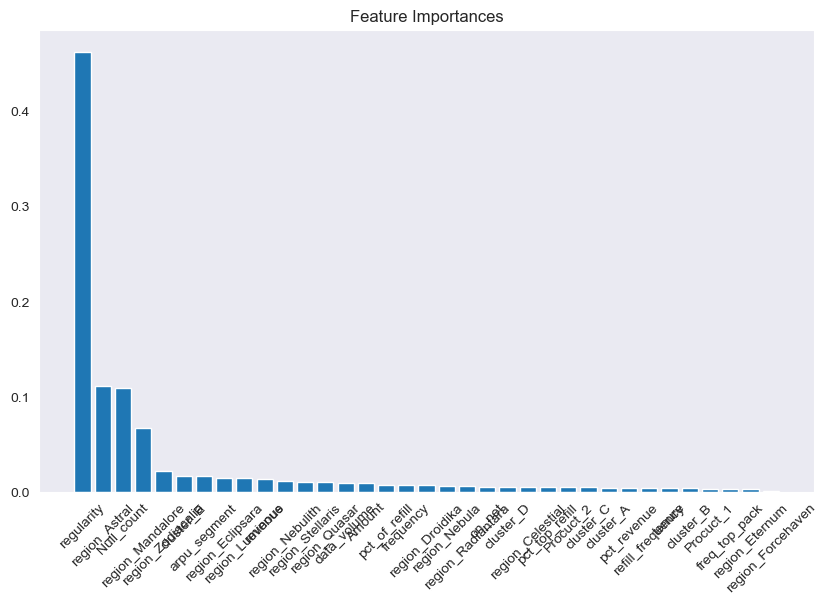

XGBoost Metrics:
Precision: 0.5594
Recall: 0.8709
F1 Score: 0.6812
AUC-ROC: 0.9248

________________________________________________________


In [21]:
model_xgb2 = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 7,
    n_estimators = 200,
    objective='binary:logistic',  
    eval_metric='auc',
    reg_alpha = 0.02, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb2.fit(X_train, y_train)
y_pred = model_xgb2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb2.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb2.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

In [115]:
y_test = targets

Accuracy: 0.847208847646561
Confusion Matrix:
[[257729  48437]
 [  9159  61634]]
___________________________
F1 Score: 0.6815507784854918
Feature ranking:
regularity: 0.48233529925346375
region_Astral: 0.10974600911140442
Null_count: 0.10507426410913467
region_Mandalore: 0.06331063061952591
region_Zodiacalia: 0.020693425089120865
arpu_segment: 0.017751790583133698
cluster_E: 0.015669232234358788
region_Nebulith: 0.013314035721123219
revenue: 0.012576845474541187
region_Eclipsara: 0.012467156164348125
region_Luminous: 0.011760573834180832
region_Quasar: 0.011066220700740814
region_Stellaris: 0.01022463571280241
data_volume: 0.009471317753195763
Amount: 0.009282832965254784
region_Droidika: 0.008331289514899254
pct_top_refill: 0.007410102058202028
region_Nebula: 0.006869805045425892
pct_of_refill: 0.006589941214770079
frequency: 0.006460242904722691
on_net: 0.005550887435674667
Procuct_2: 0.00504497392103076
cluster_B: 0.004854536149650812
refill_frequency: 0.004702044650912285
region_Ra

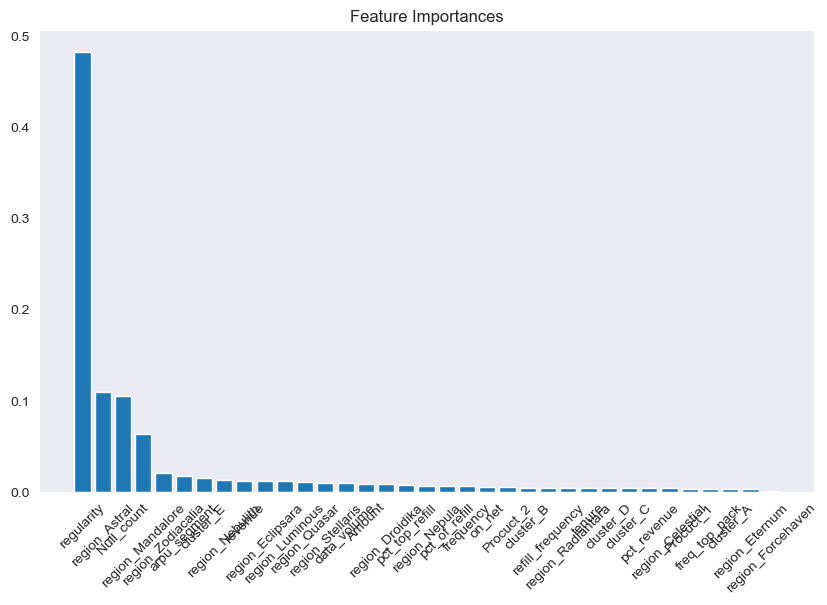

XGBoost Metrics:
Precision: 0.5599
Recall: 0.8706
F1 Score: 0.6816
AUC-ROC: 0.9249

________________________________________________________


In [22]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 15,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    reg_alpha = 0.5, 
    reg_lambda = 0.01,
    verbosity = 2,
    nthread = -1,
    random_state=0
)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

Test the model on entire dataset

In [23]:
y_pred = model_xgb.predict(features)
accuracy = accuracy_score(targets, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(targets, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(targets, y_pred)
print("F1 Score:", f1)
precision_xgb = precision_score(targets, y_pred)
recall_xgb = recall_score(targets, y_pred)
f1_xgb = f1_score(targets, y_pred)
auc_roc_xgb = roc_auc_score(targets, model_xgb.predict_proba(features)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

Accuracy: 0.848352670121512
Confusion Matrix:
[[1032276  193043]
 [  35616  246899]]
___________________________
F1 Score: 0.6834981182271056
XGBoost Metrics:
Precision: 0.5612
Recall: 0.8739
F1 Score: 0.6835
AUC-ROC: 0.9265

________________________________________________________


In [332]:
features.drop(columns='lgb_pred',inplace=True)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Number of positive: 514762, number of negative: 857936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3439
[LightGBM] [Info] Number of data points in the train set: 1372698, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375000 -> initscore=-0.510825
[LightGBM] [Info] Start training from score -0.510825
Accuracy: 0.8771507081889949
Confusion Matrix:
[[348446  18935]
 [ 36636  48334]]
___________________________
F1 Score: 0.6349752691491668


<Figure size 1000x600 with 0 Axes>

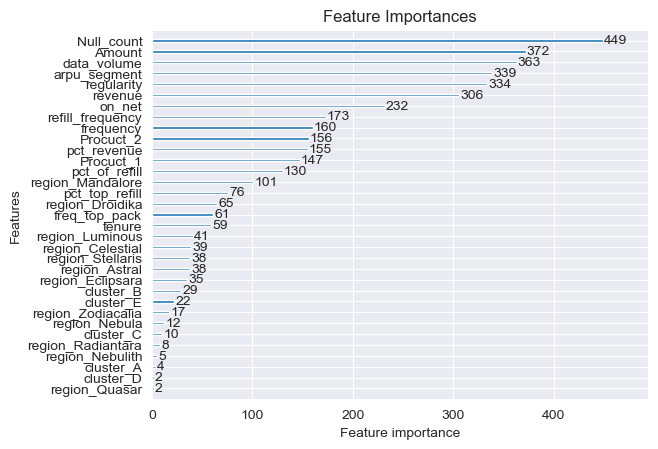

LGB Metrics:
Accuracy: 0.8772
Precision: 0.7185
Recall: 0.5688
F1 Score: 0.6350
AUC-ROC: 0.9216



In [361]:
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'dart',
    'max_depth': 10,
    'random_state': 0,
    'num_leaves': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'n_estimators': 20,
    'class_weight': 'is_unbalance',
    'colsample_bytree':0.9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01 
}

# Train the model
num_round = 100
model_lgb = lgb.train(params, train_data, num_round)

# Make predictions on the test set
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

# Convert probability predictions to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_lgb)  # Adjust max_num_features as needed
plt.title("Feature Importances")
plt.show()
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
precision_lgb = precision_score(y_test, y_pred_binary)
recall_lgb = recall_score(y_test, y_pred_binary)
f1_lgb = f1_score(y_test, y_pred_binary)
auc_roc_lgb = roc_auc_score(y_test, y_pred)

print("LGB Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1 Score: {f1_lgb:.4f}")
print(f"AUC-ROC: {auc_roc_lgb:.4f}\n")


Accuracy: 0.8772530663189715
Confusion Matrix:
[[1161908   63411]
 [ 121671  160844]]
___________________________
F1 Score: 0.634781064388184


<Figure size 1000x600 with 0 Axes>

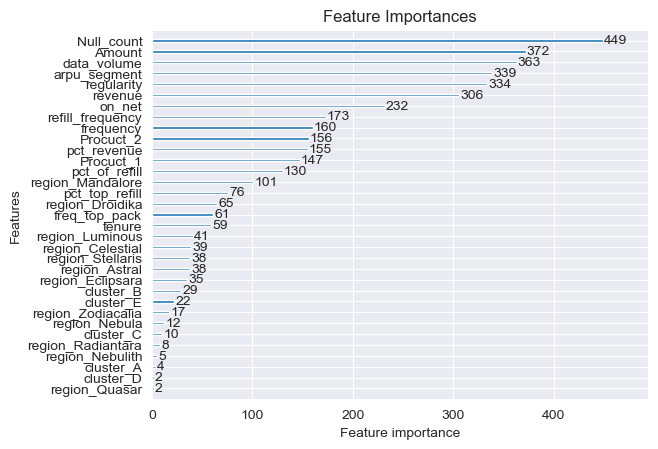

LGB Metrics:
Accuracy: 0.8773
Precision: 0.7172
Recall: 0.5693
F1 Score: 0.6348
AUC-ROC: 0.9218



In [362]:
features.drop(columns='lgb_pred',inplace=True)
y_pred = model_lgb.predict(features, num_iteration=model_lgb.best_iteration)
features['lgb_pred'] = y_pred
accuracy = accuracy_score(targets, np.round(y_pred))
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(targets, np.round(y_pred))
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(targets, np.round(y_pred))
print("F1 Score:", f1)
plt.figure(figsize=(10, 6))
lgb.plot_importance(model_lgb) 
plt.title("Feature Importances")
plt.show()
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(targets, y_pred_binary)
precision_lgb = precision_score(targets, y_pred_binary)
recall_lgb = recall_score(targets, y_pred_binary)
f1_lgb = f1_score(targets, y_pred_binary)
auc_roc_lgb = roc_auc_score(targets, y_pred)

print("LGB Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1 Score: {f1_lgb:.4f}")
print(f"AUC-ROC: {auc_roc_lgb:.4f}\n")

In [337]:
final_pred = np.round(model_lgb.predict(final_test))
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
#result_df.to_csv('Submission5.1.2.csv',index=False)
result_df.to_csv('Submission5.Final3.Lgb.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV          0.0
1       ID_04KNWHGV5783          0.0
2       ID_CXS07G6VLB2U          0.0
3       ID_N3NFJJVHS25K          0.0
4       ID_R36J4ROT93E9          1.0
...                 ...          ...
380122  ID_MGZSA4ICBD9O          0.0
380123  ID_XGDT520DFBLP          0.0
380124  ID_9RDB792PB5Q4          0.0
380125  ID_KDTJHH8L8Z13          0.0
380126  ID_2F6Y446GS8T3          1.0

[380127 rows x 2 columns]
0.0    269942
1.0    110185
Name: Predictions, dtype: int64


In [365]:
over_sampler = RandomOverSampler(sampling_strategy=0.5)  # You can adjust the sampling strategy
under_sampler = RandomUnderSampler(sampling_strategy=0.9)  # You can adjust the sampling strategy

pipeline = Pipeline([
    ('over', over_sampler),
    ('under', under_sampler)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)

# Apply the pipeline to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
X_train, y_train = X_resampled, y_resampled 
print(X_train, y_train)

          tenure    Amount  refill_frequency    revenue  arpu_segment  \
0       3.218876  7.849753          1.609438   7.853080      6.755408   
1       3.218876  7.922047          3.367296   7.989320      6.891534   
2       3.218876  5.369149          0.693147   5.369149      4.281792   
3       3.218876  4.734420          3.576751  11.821386     10.964085   
4       3.218876  7.849753          0.693147   7.848087      6.750423   
...          ...       ...               ...        ...           ...   
905596  2.944439  6.260076          3.734522  11.826357     10.963434   
905597  3.218876  6.356038          3.764411  11.827252     10.963330   
905598  3.218876  6.325402          3.792432  11.827252     10.963291   
905599  3.218876  6.325402          3.792432  11.827252     10.963291   
905600  3.218876  6.325402          3.792432  11.827252     10.963291   

        frequency  data_volume    on_net  Procuct_1  Procuct_2  ...  \
0        1.945910     9.675645  0.000000   0.000000 

In [283]:
y_train.value_counts()

0    689363
1    551491
Name: Target, dtype: int64

In [373]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.01,
    max_dephth = 5,
    n_estimators = 25,
    objective='reg:logistic',  
    eval_metric='map',
    reg_alpha = 0.01, 
    reg_lambda = 0.01,
    random_state=0
)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='map', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dephth=5, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=25,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy: 0.8522231629862651
Confusion Matrix:
[[313406  53975]
 [ 12872  72098]]
___________________________
F1 Score: 0.683254123567235
Feature ranking:


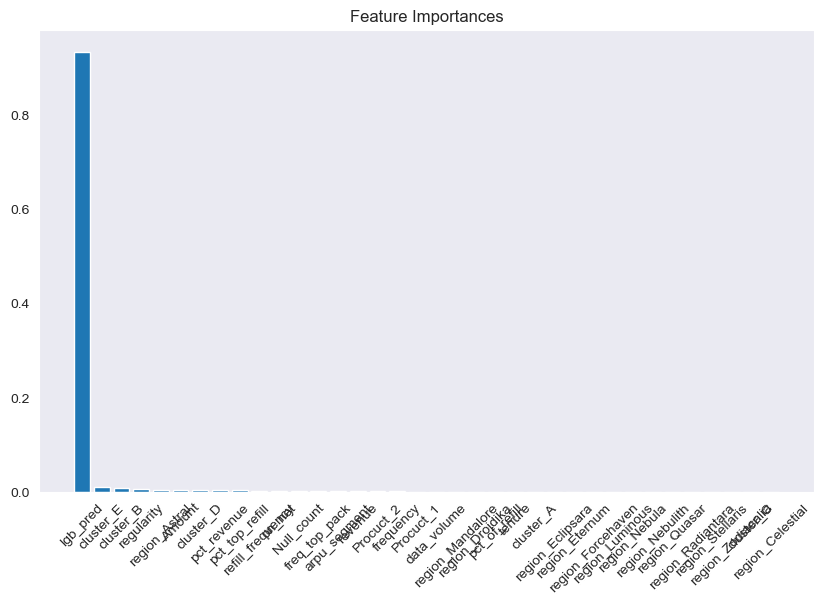

XGBoost Metrics:
Precision: 0.5719
Recall: 0.8485
F1 Score: 0.6833
AUC-ROC: 0.9223

________________________________________________________


In [374]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importances")
plt.show()
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
auc_roc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

In [375]:
y_pred = model_xgb.predict(features)
accuracy = accuracy_score(targets, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(targets, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print('___________________________')
f1 = f1_score(targets, y_pred)
print("F1 Score:", f1)
precision_xgb = precision_score(targets, y_pred)
recall_xgb = recall_score(targets, y_pred)
f1_xgb = f1_score(targets, y_pred)
auc_roc_xgb = roc_auc_score(targets, model_xgb.predict_proba(features)[:, 1])
print("XGBoost Metrics:")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_roc_xgb:.4f}\n")
print('________________________________________________________')

Accuracy: 0.8529022425545517
Confusion Matrix:
[[1045992  179327]
 [  42472  240043]]
___________________________
F1 Score: 0.683995241385697
XGBoost Metrics:
Precision: 0.5724
Recall: 0.8497
F1 Score: 0.6840
AUC-ROC: 0.9228

________________________________________________________


In [376]:
final_test['lgb_pred'] = model_lgb.predict(final_test)
final_pred = model_xgb.predict(final_test)
final_pred
data = list(zip(test_df.index, final_pred))

result_df = pd.DataFrame(data, columns=['ID', 'Predictions'])
print(result_df)
print(result_df['Predictions'].value_counts())
#result_df.to_csv('Submission5.1.2.csv',index=False)
result_df.to_csv('Submission5.FinalTest.csv',index=False)

                     ID  Predictions
0       ID_LZ8K373W7EWV            0
1       ID_04KNWHGV5783            0
2       ID_CXS07G6VLB2U            0
3       ID_N3NFJJVHS25K            0
4       ID_R36J4ROT93E9            1
...                 ...          ...
380122  ID_MGZSA4ICBD9O            0
380123  ID_XGDT520DFBLP            0
380124  ID_9RDB792PB5Q4            0
380125  ID_KDTJHH8L8Z13            0
380126  ID_2F6Y446GS8T3            1

[380127 rows x 2 columns]
0    274503
1    105624
Name: Predictions, dtype: int64
